In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/fix/feature_selected_reg_full.csv')

In [4]:
df.dtypes

share_price                      float64
OECD_CLI_index                   float64
CSI_index                        float64
gdp_per_capita_residual          float64
gdp_per_capita_rollstd12         float64
PPI_diff1                        float64
gdp_per_capita_diff1             float64
gdp_per_capita_diff3             float64
gdp_per_capita_pct_change1       float64
1_year_rate                      float64
3_months_rate                    float64
6_months_rate                    float64
CPI                              float64
INDPRO                           float64
10_year_rate                     float64
unemployment_rate                float64
PPI                              float64
gdp_per_capita                   float64
CSI_index_trend                  float64
OECD_CLI_index_trend             float64
PPI_CPI_diff                     float64
3_months_rate_rollmin12          float64
INDPRO_rollstd12                 float64
PPI_rollstd12                    float64
3_months_rate_di

0:	learn: 4.4951504	total: 56.3ms	remaining: 56.3s
100:	learn: 1.8672689	total: 161ms	remaining: 1.44s
200:	learn: 1.4547885	total: 265ms	remaining: 1.05s
300:	learn: 1.1167853	total: 376ms	remaining: 872ms
400:	learn: 0.8793422	total: 483ms	remaining: 721ms
500:	learn: 0.7369129	total: 586ms	remaining: 584ms
600:	learn: 0.6331480	total: 690ms	remaining: 458ms
700:	learn: 0.5333206	total: 793ms	remaining: 338ms
800:	learn: 0.4502875	total: 895ms	remaining: 222ms
900:	learn: 0.3908204	total: 1s	remaining: 110ms
999:	learn: 0.3200264	total: 1.11s	remaining: 0us
0:	learn: 4.4861381	total: 1.85ms	remaining: 1.84s
100:	learn: 1.9429449	total: 112ms	remaining: 995ms
200:	learn: 1.5037567	total: 222ms	remaining: 883ms
300:	learn: 1.1508382	total: 330ms	remaining: 767ms
400:	learn: 0.8881962	total: 438ms	remaining: 654ms
500:	learn: 0.6952710	total: 555ms	remaining: 553ms
600:	learn: 0.5616839	total: 665ms	remaining: 442ms
700:	learn: 0.4667473	total: 771ms	remaining: 329ms
800:	learn: 0.38222

/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

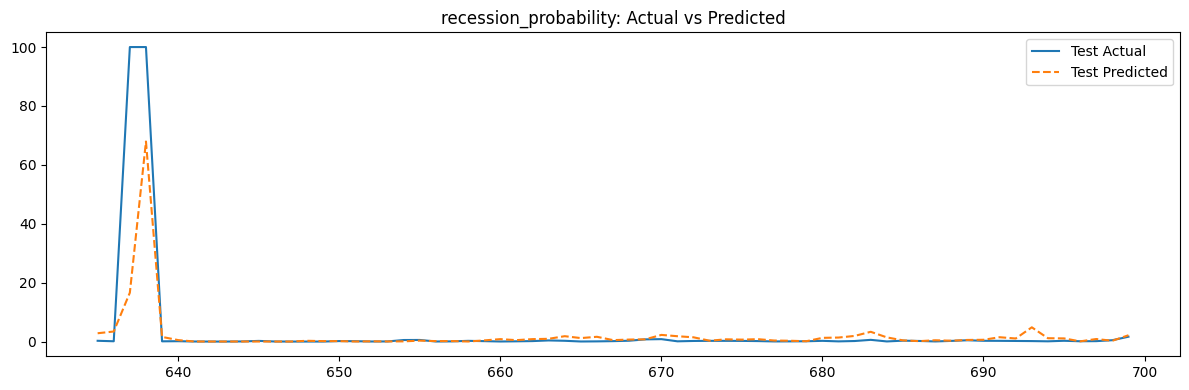

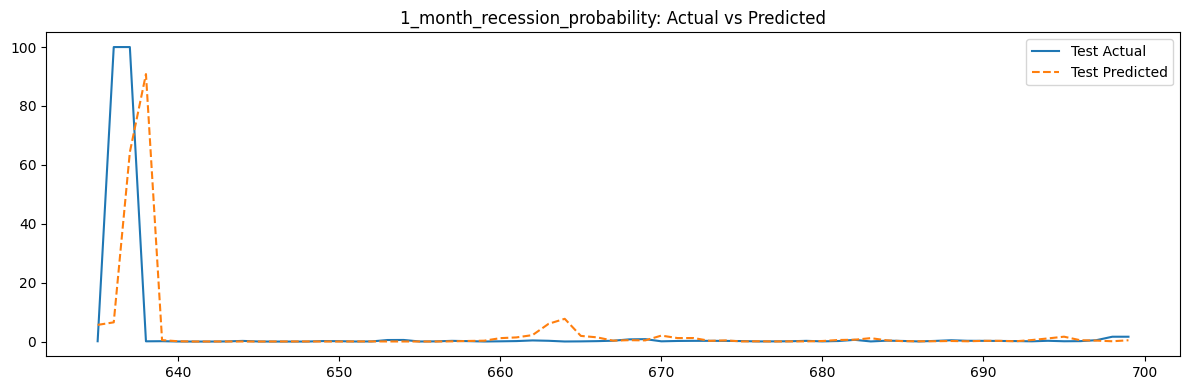

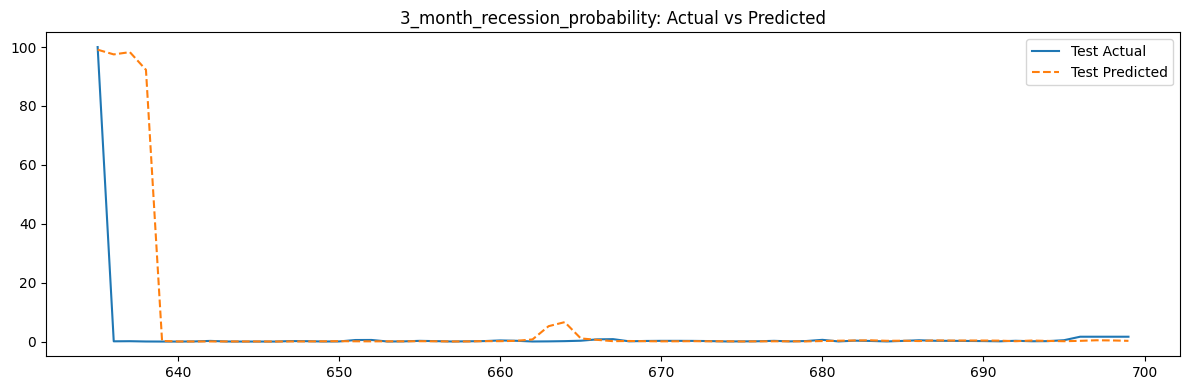

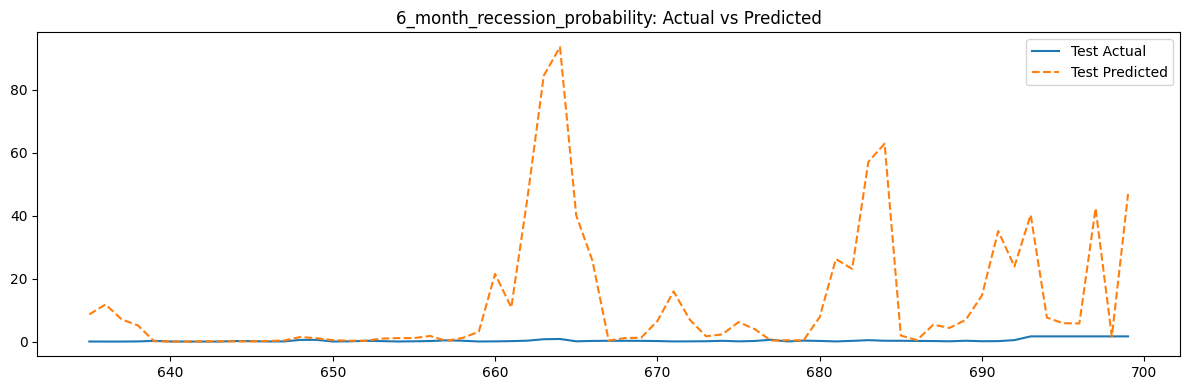

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Key indicators (for reference)
# -------------------------
key_indicators = [
    '1_year_rate','3_months_rate','6_months_rate','CPI','INDPRO',
    '10_year_rate','share_price','unemployment_rate','PPI',
    'OECD_CLI_index','CSI_index','gdp_per_capita'
]

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Logit transform for [0,100] probabilities
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Step 1: RegressorChain for first 3 targets
# -------------------------
chain_targets = recession_targets[:3]

X_train_chain = X_train.copy()
X_test_chain  = X_test.copy()
y_train_chain = logit_transform(y_train[chain_targets].values)
y_test_chain  = y_test[chain_targets]

# CatBoost as base regressor
base_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    subsample=0.9,
    random_seed=42,
    loss_function="RMSE",
    verbose=100
)

chain_model = RegressorChain(base_model)
chain_model.fit(X_train_chain, y_train_chain)

# Predict first 3 targets and invert logit
preds_chain_logit = chain_model.predict(X_test_chain)
preds_chain_df = pd.DataFrame(
    inv_logit_transform(preds_chain_logit),
    columns=chain_targets,
    index=X_test.index
).clip(0, 100)

# -------------------------
# Step 2: Separate model for 6-month target
# -------------------------
target_6m = "6_month_recession_probability"

# Include predictions of first 3 targets as extra features
X_train_6m = X_train.copy()
X_train_6m[chain_targets] = inv_logit_transform(chain_model.predict(X_train_chain))
X_test_6m = X_test.copy()
X_test_6m[chain_targets] = preds_chain_df

y_train_6m = logit_transform(y_train[target_6m].values)
y_test_6m  = y_test[target_6m]

model_6m = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    subsample=0.9,
    random_seed=42,
    loss_function="RMSE",
    verbose=100
)

train_pool_6m = Pool(X_train_6m, y_train_6m)
test_pool_6m = Pool(X_test_6m)
model_6m.fit(train_pool_6m)

# Predict and invert logit
pred_6m = inv_logit_transform(model_6m.predict(test_pool_6m)).clip(0, 100)

# -------------------------
# Combine all predictions
# -------------------------
preds_test_final = preds_chain_df.copy()
preds_test_final[target_6m] = pred_6m

# -------------------------
# Evaluate
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test_final, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(test_df.index, preds_test_final[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
import pickle
import os

# Create an output folder (optional)
os.makedirs("models", exist_ok=True)

# Save the RegressorChain model
with open("models/recession_chain_model.pkl", "wb") as f:
    pickle.dump(chain_model, f)

# Save the 6-month CatBoost model
with open("models/recession_6m_model.pkl", "wb") as f:
    pickle.dump(model_6m, f)
